In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load Dataset
df1 = pd.read_csv('./mtcars.csv')
df1.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
#Drop model Column and Dataset Attributes
df1 = df1.drop('model',axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      32 non-null     int64  
 4   drat    32 non-null     float64
 5   wt      32 non-null     float64
 6   qsec    32 non-null     float64
 7   vs      32 non-null     int64  
 8   am      32 non-null     int64  
 9   gear    32 non-null     int64  
 10  carb    32 non-null     int64  
dtypes: float64(5), int64(6)
memory usage: 2.9 KB


In [4]:
#Define x and y variable
x = df1.drop('mpg',axis=1).to_numpy()
y = df1['mpg'].to_numpy()

#Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

x_2 = sc.transform(x)

In [5]:
#Model
from sklearn.linear_model import LinearRegression
model = [LinearRegression()]

In [6]:
#Create Model Comparison
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

#Scoring Parameters
scoring = {'MAE':'neg_mean_absolute_error',
           'MSE':'neg_mean_squared_error'}

#Model Creation
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in model:
    
    #K-Fold CV
    kfcv = alg.fit(x_train2, y_train)
    kf = KFold(n_splits=10, shuffle=True, random_state=100)
    KFcv = cross_validate(kfcv, x_2, y, scoring=scoring,
                         cv=kf)
    
    #Repeated K-Fold CV
    rkfcv = alg.fit(x_train2, y_train)
    rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    rKFcv = cross_validate(rkfcv, x_2, y, scoring=scoring,
                         cv=rkf)
    
    #Shuffle-Split
    rsmodel=alg.fit(x_train2, y_train)
    rs = ShuffleSplit(n_splits=10, test_size=.20, random_state=100)
    rscv = cross_validate(rsmodel, x_2, y, scoring=scoring,
                         cv=rs)
        
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Algorithm Name'] = MLA_name
    MLA_compare.loc[row_index, 'KFcv Model'] = round(np.sqrt(-KFcv['test_MSE'].mean()),2)
    MLA_compare.loc[row_index, 'rKFcv Model'] = round(np.sqrt(-rKFcv['test_MSE'].mean()),2)
    MLA_compare.loc[row_index, 'ShuffleSplit Model'] = round(np.sqrt(-rscv['test_MSE'].mean()),2)
    
    row_index+=1

MLA_compare

,Algorithm Name,KFcv Model,rKFcv Model,ShuffleSplit Model
0,LinearRegression,3.83,3.67,3.64


In [7]:
#LOOCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn import metrics

model = LinearRegression()
loocv =  LeaveOneOut()
# evaluate model
scoreloocv = cross_val_score(model, x_2, y, scoring='neg_mean_absolute_error', cv=loocv)
print('RMSE - LOOCV:',round(mean(-scoreloocv),2))                      

RMSE - LOOCV: 2.74


In [8]:
#Original Model - RMSE

n_inter = 1000
RMSE_org =list()

for i in range(n_inter):
    
    #Model
    method = LinearRegression()
    #Create Train and Test Datasets
    x_trainorg,x_testorg,y_trainorg,y_testorg=train_test_split(x,y,test_size=0.2)
    #Scale the Data
    x_trainorg2 = sc.fit_transform(x_trainorg)
    x_testorg2 = sc.transform(x_testorg)
    #Create the Model
    method.fit(x_trainorg2,y_trainorg)
    predictorg = method.predict(x_testorg2)
    RMSEorg = np.sqrt(metrics.mean_squared_error(y_testorg,predictorg))
    RMSE_org.append(RMSEorg)                     
       
MeanRMSE_org = mean(RMSE_org)
print('RMSE - Original Model:',round(MeanRMSE_org,2))                      

RMSE - Original Model: 3.68


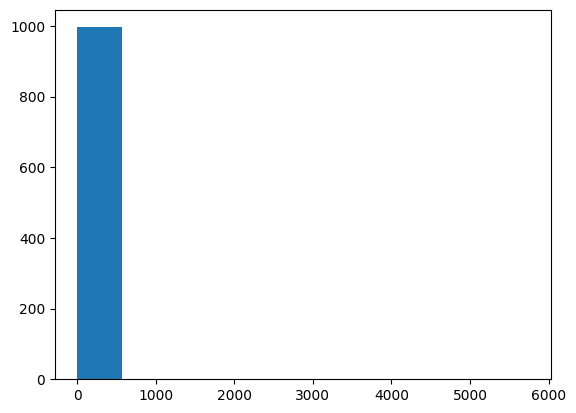

Bootstrapping RMSE: 24.77

95.0% Confidence Interval: RMSE 3.62 to 61.74


In [9]:
# configure bootstrap
from sklearn.utils import resample

n_iterations = 1000
n_size = int(len(df1) * 0.50)
# run bootstrap
stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(df1.values, n_samples=n_size)
    test = np.array([x for x in df1.values if x.tolist() not in train.tolist()])
    # fit model
    model = LinearRegression()
    model.fit(train[:,1:], train[:,0])
    # evaluate model
    predictions = model.predict(test[:,1:])
    score = np.sqrt(metrics.mean_squared_error(test[:,0], predictions))
    #print(score)
    stats.append(score)
# plot scores
plt.hist(stats)
plt.show()

#Mean of RMSE
meanRMSE = mean(stats)
print('Bootstrapping RMSE:',round(meanRMSE,2))

#Confidence Intervals
alpha = .95
p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(stats, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(stats, p)
print('\n{}% Confidence Interval: RMSE {} to {}'.format(alpha*100,round(lower,2),round(upper,2)))  